In [271]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

In [272]:
 matches_df = pd.read_parquet("./esta/parsed/matches.parquet")
 rounds_df = pd.read_parquet("./esta/parsed/rounds.parquet")
 kills_df = pd.read_parquet("./esta/parsed/kills.parquet")
 damages_df = pd.read_parquet("./esta/parsed/damages.parquet") 
 grenades_df = pd.read_parquet("./esta/parsed/grenades.parquet") 
 bomb_events_df = pd.read_parquet("./esta/parsed/bomb_events.parquet") 
 weapon_fires_df = pd.read_parquet("./esta/parsed/weapon_fires.parquet") 
 flashes_df = pd.read_parquet("./esta/parsed/flashes.parquet") 
 frames_df = pd.read_parquet("./esta/parsed/frames.parquet")
 players_df = pd.read_parquet("./esta/parsed/players.parquet") 
 team_frames_df = pd.read_parquet("./esta/parsed/team_frames.parquet") 
 player_frames_df = pd.read_parquet("./esta/parsed/player_frames.parquet") 
 inventory_df = pd.read_parquet("./esta/parsed/inventory.parquet") 
 bomb_location_df = pd.read_parquet("./esta/parsed/bomb_location.parquet") 
 projectiles_df = pd.read_parquet("./esta/parsed/projectiles.parquet") 
 smokes_df = pd.read_parquet("./esta/parsed/smokes.parquet") 
 fires_df = pd.read_parquet("./esta/parsed/fires.parquet") 

image_dim = 1024

In [273]:
with open(".awpy/maps/map-data.json", "r") as f:
    map_data_all = json.load(f)

print(type(map_data_all))

<class 'dict'>


# Analyze Over 1 Specific Map

In [274]:
selected_map = 'de_mirage'

In [275]:
selected_matches = matches_df[matches_df.map_name == selected_map]
selected_matches.head()

,client_name,map_name,tick_rate,playback_ticks,playback_frames_count,parsed_to_frame_idx,match_id,demo_id,competition_name,hltv_url,match_date,match_name
0,GOTV Demo,de_mirage,127,343251,342767,342784,0839a031-0e2c-4c03-b4bc-b5ba05fe669a,01746483-b3bd-4e4b-a2f2-0de97b17600d,PGL Major Antwerp 2022,https://www.hltv.org/matches/2356160/heroic-vs...,1652781600000,heroic-vs-vitality-pgl-major-antwerp-2022
0,GOTV Demo,de_mirage,127,471790,471564,471581,0a075b4d-576e-46f2-b944-fe9542faee54,04f0fb8f-a4d7-497c-857e-316300fadee3,IEM Katowice 2022,https://www.hltv.org/matches/2354381/furia-vs-...,1645124400000,furia-vs-astralis-iem-katowice-2022
0,GOTV Demo,de_mirage,127,426251,425998,426016,a98ffca7-e968-4a54-9e8f-22f101c2502b,022866a3-090e-42eb-ab8e-aa553a575ada,IEM Katowice 2021,https://www.hltv.org/matches/2346573/faze-vs-f...,1613905200000,faze-vs-furia-iem-katowice-2021
0,GOTV Demo,de_mirage,127,441259,440692,440707,a56115fd-a0ba-4eea-a618-91fd6c57177c,015f7c8d-2bc0-4d83-88e7-60648d2b221c,BLAST Premier Fall Showdown 2021,https://www.hltv.org/matches/2351973/heroic-vs...,1634034600000,heroic-vs-poggerz-blast-premier-fall-showdown-...
0,GOTV Demo,de_mirage,127,493224,492014,492029,f218743d-5e8b-436e-91bd-b7b3664c56c3,0418eb19-853e-4b56-955c-d3eedf2b7e12,BLAST Premier Spring Final 2021,https://www.hltv.org/matches/2349173/natus-vin...,1623853200000,natus-vincere-vs-faze-blast-premier-spring-fin...


In [276]:
selected_match = selected_matches.iloc[0]

## Location of players over one round

In [283]:
idx_pf_df = player_frames_df.set_index(["match_id","round_num","frame_id"])

In [284]:
def transform_coord(map_data,player_loc,inplace=False):
    if not inplace:
        result = player_loc.copy()
    else:
        result = player_loc
        
    pos_x = map_data["pos_x"]
    pos_y = map_data["pos_y"]
    scale = map_data["scale"]

    result["x"] = (result["x"] - pos_x) / scale
    result["y"] = image_dim - (pos_y - result["y"]) / scale

    if not inplace:
        return result

In [285]:
def plot_loc_on_map(all_map_data,map_name,player_loc,color_by):
    fig, ax = plt.subplots(figsize=(8, 6))
    map_img = plt.imread(f".awpy/maps/{map_name}.png")
    ax.imshow(map_img, extent=[0, image_dim, 0, image_dim])

    transformed = transform_coord(all_map_data[map_name],player_loc).reset_index()[["x","y",color_by,"side"]]
    transformed["side"] = transformed["side"].str.lower()
    
    ct_positions = transformed[transformed['side'] == 'ct']
    t_positions = transformed[transformed['side'] == 't']
    
    scatter_ct = ax.scatter(ct_positions["x"], ct_positions["y"], 
                            c=ct_positions[color_by], cmap='Blues', 
                            alpha=0.5, s=10, label='CT')
        
        # Add smaller color bar for CT with customizations
    cbar_ct = fig.colorbar(scatter_ct, ax=ax, location='left', pad=0.02, 
                            fraction=0.046, shrink=0.6)
    cbar_ct.set_label('CT Frame', fontsize=8)
    cbar_ct.ax.tick_params(labelsize=7)
    
    scatter_t = ax.scatter(t_positions["x"], t_positions["y"], 
                        c=t_positions[color_by], cmap='Reds', 
                        alpha=0.5, s=10, label='T')
        
        # Add smaller color bar for T with customizations
    cbar_t = fig.colorbar(scatter_t, ax=ax, location='right', pad=0.02, 
                            fraction=0.046, shrink=0.6)
    cbar_t.set_label('T Frame', fontsize=8)
    cbar_t.ax.tick_params(labelsize=7)
    
    ax.set_title(f"Player Locations on {map_name}")
    ax.set_xlabel("X Coordinate (pixels)")
    ax.set_ylabel("Y Coordinate (pixels)")
    ax.set_xlim(0, image_dim)
    ax.set_ylim(0, image_dim)
    plt.tight_layout()
    plt.show()

/tmp/nix-shell.EcwU3H/ipykernel_30597/3427877408.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  plot_loc_on_map(map_data_all,selected_map,idx_pf_df.loc[(selected_match.match_id,3)],color_by="frame_id")


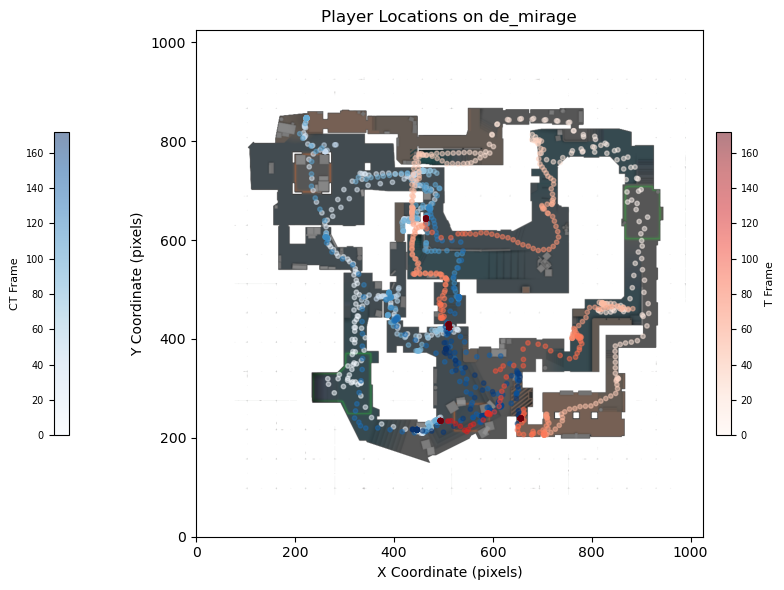

In [286]:
plot_loc_on_map(map_data_all,selected_map,idx_pf_df.loc[(selected_match.match_id,3)],color_by="frame_id")

In [287]:
idx_f_df = flashes_df.set_index(["match_id", "round_num", "tick"])

idx_f_df.loc[(selected_match.match_id, 10)].groupby('attacker_steam_id')\
.agg(players_flashed=('player_steam_id', 'count'))

/tmp/nix-shell.EcwU3H/ipykernel_30597/4142980014.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  idx_f_df.loc[(selected_match.match_id, 10)].groupby('attacker_steam_id')\


,players_flashed
attacker_steam_id,
76561197983956651,1
76561197989744167,2
76561197996678278,1
76561198004115516,9
76561198004854956,6
76561198064864198,3
76561198113666193,3
76561198160709585,4


In [282]:
idx_f_df.columns

Index(['seconds', 'clock_time', 'attacker_steam_id', 'attacker_name',
       'attacker_team', 'attacker_side', 'attacker_x', 'attacker_y',
       'attacker_z', 'attacker_view_x', 'attacker_view_y', 'player_steam_id',
       'player_name', 'player_team', 'player_side', 'player_x', 'player_y',
       'player_z', 'player_view_x', 'player_view_y', 'flash_duration'],
      dtype='object')